### Simple Time-Series Prediction with LSTM Tensorflow 
    The notebook aims to create a barebones LSTM neural network in pure Tensorflow. The network is used to predict the next value of a sine wave using previous values.
    
    The network can be easily customized by adding more network layers (eg. 1-D Convolutional Layers), or by adding more inputs and outputs or by increasing or reducing the number of past values the network can observe before predicting the next output.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as mp
%matplotlib inline

C:\Users\Anthony\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Creating a Sine time series
    The time series is created with the minimum and maximum value of x-axis and the number of points. The number of points are used to determine the resolution of the time-series. 
    
    The batch function outputs a random segment of the time-series. It functions by starting at a random point in the time series and counting upto to the number of points required.

In [2]:
class SineTimeSeries():
    def __init__(self, x_min, x_max, n):
        self.xmin = x_min
        self.xmax = x_max
        self.res = (x_max - x_min)/n
        self.x = np.linspace(x_min, x_max, n)
        self.y = np.sin(self.x)
        
    def batch(self, num_points):
        # get a random starting point
        t_start = self.xmin + np.random.rand(1)*((self.xmax-self.res*num_points) - self.xmin)
        
        # calculate the ending point with the resolution and number of points
        t_end = t_start + self.res*num_points
        
        # generate the batch
        x_batch = np.linspace(t_start, t_end, num_points)
        y_batch = np.sin(x_batch)
        
        return x_batch, y_batch
        

In [3]:
# create a new time series
Ts = SineTimeSeries(0,10,100)

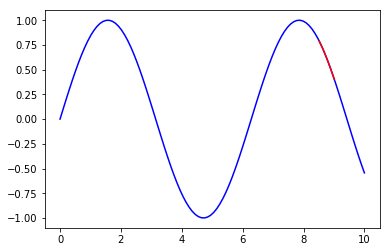

In [4]:
# get a random batch
x_bat, y_bat = Ts.batch(5)

# plot the timeseries
mp.plot(Ts.x, Ts.y, 'b-')
mp.plot(x_bat, y_bat, 'r-')


#### LSTM Neural Network
        The LSTM neural network has a input layer (Y_old), which accepts 5 old values (this can be modified to any number of past observation values). The label Y, is the correct next value in the sine wave given the previous 5 values.
        
        The LSTM layer is made up of 256 units. The tf.contrib.rnn.LSTMCell can be replaced with GRUCell, RNNCell or any other relavant cell type. The Projection wrapper, unwraps the LSTM to provide a singe output required by the problem. 

In [5]:
with tf.variable_scope('input'):
    Y_old = tf.placeholder(dtype=tf.float32, shape=[None, 1,  5], name='Y_old')

In [6]:
with tf.variable_scope('label'):
    Y = tf.placeholder(dtype=tf.float32, shape=[None, 1,  1], name='Y')

In [7]:
with tf.variable_scope('lstm'):
    lstm = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.LSTMCell(num_units=256, activation=tf.nn.relu), output_size=1)
    Y_hat, states = tf.nn.dynamic_rnn(lstm, Y_old, dtype=tf.float32)

#### Cost Fuction and Optimizer
    The Cost function is MSE between the prediction (Y_hat) and the actual output (Y). 
    
    The optimizer to reduce the cost function is Adam Optimizer.

In [8]:
# cost function
with tf.variable_scope('cost'):
    cost = tf.reduce_mean(tf.squared_difference(Y_hat, Y))

In [9]:
# Optimizers
learning_rate = 0.0001
with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#### Run Session and predict the output
    Run the session by feeding in the random batches of Y_old values and correct Y labels. 
    
    After the network is trained, we feed the network with sequential values of sine wave and let the network predict the next value

In [11]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # run the training loop
    for i in range(0, 10000):
        # get the inputs for this batch
        _, y_bat = Ts.batch(6)
        y_old_in = y_bat[:-1].reshape(-1, 1, 5)
        y_in = y_bat[-1].reshape(-1, 1, 1)
        
        # feed the inputs
        session.run(optimizer, feed_dict={Y_old:y_old_in, Y:y_in})

        # get the current training cost
        if i%500 == 0:
            training_cost = session.run(cost, feed_dict={Y_old:y_old_in, Y:y_in})
            print("Epoch:", i, "Training:", training_cost)
            
    # perfrom prediction
    x_out = np.zeros((len(Ts.y)-6, 1)).flatten()
    y_out = np.zeros((len(Ts.y)-6, 1)).flatten()
    for i in range(0, len(Ts.y)-6):
        y_old_in = Ts.y[i:i+5].reshape(-1, 1, 5)
        x_out[i] = Ts.x[i+6]
        y_out[i] = session.run(Y_hat, feed_dict={Y_old:y_old_in})

Epoch: 0 Training: 0.026905915
Epoch: 500 Training: 2.623128e-05
Epoch: 1000 Training: 0.11739983
Epoch: 1500 Training: 0.100094095
Epoch: 2000 Training: 0.005294033
Epoch: 2500 Training: 0.0015322511
Epoch: 3000 Training: 0.0042528166
Epoch: 3500 Training: 0.042106483
Epoch: 4000 Training: 2.7427555e-05
Epoch: 4500 Training: 0.0022955884
Epoch: 5000 Training: 0.00025951274
Epoch: 5500 Training: 3.0932613e-05
Epoch: 6000 Training: 4.3222634e-09
Epoch: 6500 Training: 7.520811e-06
Epoch: 7000 Training: 0.00019189772
Epoch: 7500 Training: 3.5359648e-05
Epoch: 8000 Training: 5.5190983e-05
Epoch: 8500 Training: 3.2088898e-05
Epoch: 9000 Training: 0.0004295113
Epoch: 9500 Training: 3.5587203e-05


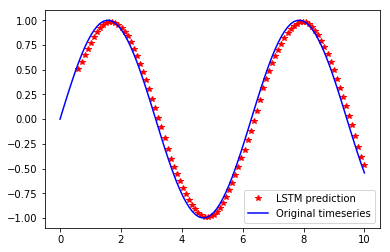

In [14]:
mp.plot(x_out, y_out,'r*', label='LSTM prediction')
mp.plot(Ts.x, Ts.y, 'b-', label='Original timeseries')
mp.legend()